In [1]:
import glob
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [2]:
info = pd.read_excel("../../1_analysis_of_rna_seq/RNAseq.xls")
info = info[~info["Replicate"].isna()]
samples = list(info["Sample"])
groups = list(sorted(set([s[:-2] for s in samples])))
as_type_list = ["SE", "A5SS", "A3SS", "MXE", "RI"]

# Gene and alternative splicing

In [3]:
data = defaultdict(list)
for t in as_type_list:
    genes = []
    for p in glob.glob("../../3_integrate_isoforms/results/rmats/pairs2/*/%s.MATS.JC.txt" % t):
        d = pd.read_csv(p, sep="\t")
        d = d[d["FDR"] < 1e-6]
        for g in d["GeneID"]:
            genes.append(g)
    data[t] = set(genes)

In [5]:
all_genes = set()
for genes in data.values():
    all_genes = all_genes | genes
counter = defaultdict(int)
for g in all_genes:
    k = tuple([g in data[t] for t in as_type_list])
    counter[k] += 1
items = list(sorted(counter.items(), key=lambda item: item[1], reverse=True))
print(len(items))

31


[2283 1247  587  462  347  274  271  246  220  213  208  197  181  159
  158  130   99   98   92   51   47   47   28   25   22   19   19   16
   10    9    3]
[3705 1447 1630 1945 4852]


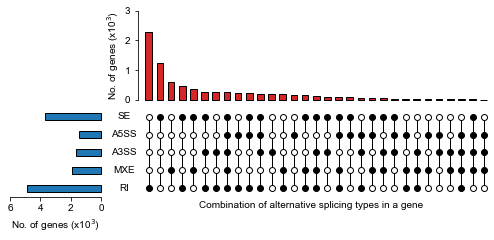

In [6]:
fig = plt.figure(figsize=(7, 3.5))
gs = GridSpec(4, 4, figure=fig, hspace=0.2, wspace=0.4, left=0.03, right=0.97, bottom=0.18, top=0.92)

ax1 = fig.add_subplot(gs[0:2, 0:1])
ax1.set_visible(False)

ax2 = fig.add_subplot(gs[0:2, 1:5])
ys = np.array([item[1] for item in items])
print(ys)
ys = ys / 1e3
xs = np.arange(len(ys))
plt.bar(xs, ys, edgecolor="black", width=0.6, color="C3", clip_on=False)
plt.xlim(-1, len(items) - 1)
plt.ylim(0, 3)
plt.ylabel("No. of genes (x10$^3$)")
if True:
    plt.xticks([])
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.spines["right"].set_visible(False)

ax3 = fig.add_subplot(gs[2:4, 0:1])
xs = np.array([len(data[t]) for t in as_type_list])
print(xs)
xs = xs / 1e3
ys = np.arange(len(xs))
plt.barh(ys, xs, edgecolor="black", color="C0", height=0.4, clip_on=False)
plt.xlim(6, 0)
plt.ylim(4.5, -0.5)
plt.xticks([0, 2, 4, 6])
plt.xlabel("No. of genes (x10$^3$)")
if True:
    plt.yticks([])
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_visible(False)
    ax3.spines["right"].set_visible(False)

ax4 = fig.add_subplot(gs[2:4, 1:5])
for y, t in enumerate(as_type_list):
    plt.text(-2.2, y, t, ha="center", va="center")
plt.xlim(-1, len(items) - 1)
plt.ylim(4.5, -0.5)
plt.xlabel("Combination of alternative splicing types in a gene")
for x in np.arange(len(items)):
    plt.plot([x, x], [0, 4], lw=1, color="black", clip_on=False, zorder=0)
    for y, v in enumerate(items[x][0]):
        color = "black" if v else "white"
        plt.scatter([x], [y], marker="o", edgecolor="black", color=color, clip_on=False, zorder=1)
if True:
    plt.xticks([])
    plt.yticks([])
    for obj in ax4.spines.values():
        obj.set_visible(False)

plt.savefig("figures/gene_and_alternative_splicing.pdf", dpi=300)


# Alternative splicing between sex

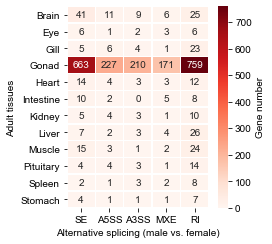

In [218]:
tissues = list(sorted(set(info["Tissue"])))
rows = []
for tissue in tissues:
    row = []
    for t in as_type_list:
        s = "Ad_%s_Fe_vs_Ad_%s_Ma" % (tissue[:2], tissue[:2])
        path = "../../3_integrate_isoforms/results/rmats/pairs2/%s/%s.MATS.JC.txt" % (s, t)
        d = pd.read_csv(path, sep="\t")
        d = d[d["FDR"] < 1e-6]
        row.append(len(set(d["GeneID"])))
    rows.append(row)
    
dat = pd.DataFrame(rows, index=tissues, columns=as_type_list)
plt.figure(figsize=(3.8, 3.5))
sns.heatmap(dat, cmap="Reds", lw=0.5, color="black", vmin=0, annot=True, fmt="d",
            cbar_kws=dict(label="Gene number"))
plt.xlabel("Alternative splicing (male vs. female)")
plt.ylabel("Adult tissues")
plt.tight_layout()
plt.savefig("figures/alternative_splicing_heatmap_sex.pdf", dpi=300)

# Alternative splicing between stage

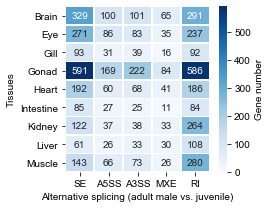

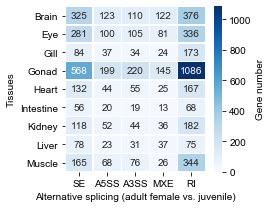

In [219]:
tissues = list(sorted(set(info[info["Stage"] == "Juvenile"]["Tissue"])))

for sex in ["Ma", "Fe"]:
    rows = []
    for tissue in tissues:
        row = []
        for t in as_type_list:
            s = "Ad_%s_%s_vs_Ju_%s_Mi" % (tissue[:2], sex, tissue[:2])
            path = "../../3_integrate_isoforms/results/rmats/pairs2/%s/%s.MATS.JC.txt" % (s, t)
            d = pd.read_csv(path, sep="\t")
            d = d[d["FDR"] < 1e-6]
            row.append(len(set(d["GeneID"])))
        rows.append(row)

    dat = pd.DataFrame(rows, index=tissues, columns=as_type_list)
    plt.figure(figsize=(3.8, 3))
    sns.heatmap(dat, cmap="Blues", lw=0.5, color="black", vmin=0, annot=True, fmt="d",
                cbar_kws=dict(label="Gene number"))
    plt.xlabel("Alternative splicing (adult %s vs. juvenile)" % ("male" if sex == "Ma" else "female"))
    plt.ylabel("Tissues")
    plt.tight_layout()
    plt.savefig("figures/alternative_splicing_heatmap_stage.%s.pdf" % sex, dpi=300)

# Comparison between groups (clustermap)

SE 1434
A5SS 444
A3SS 464
MXE 252
RI 1942


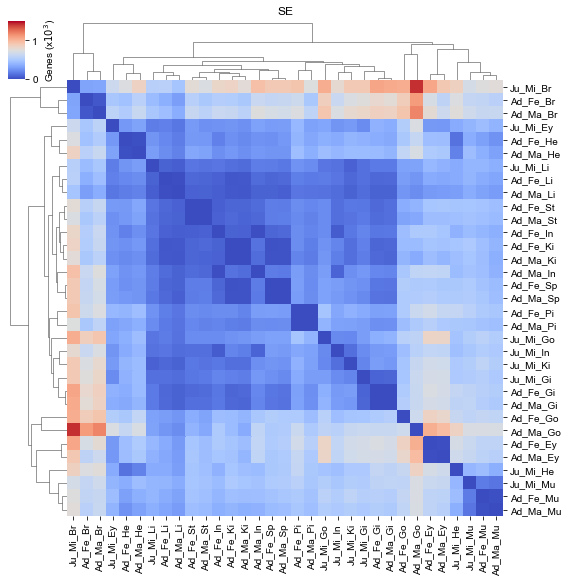

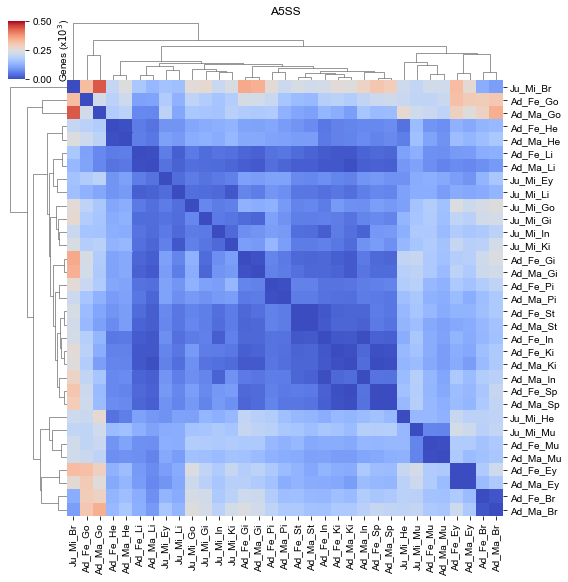

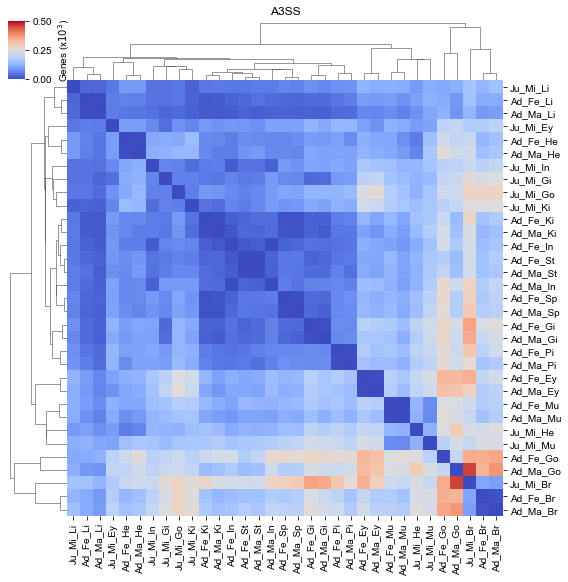

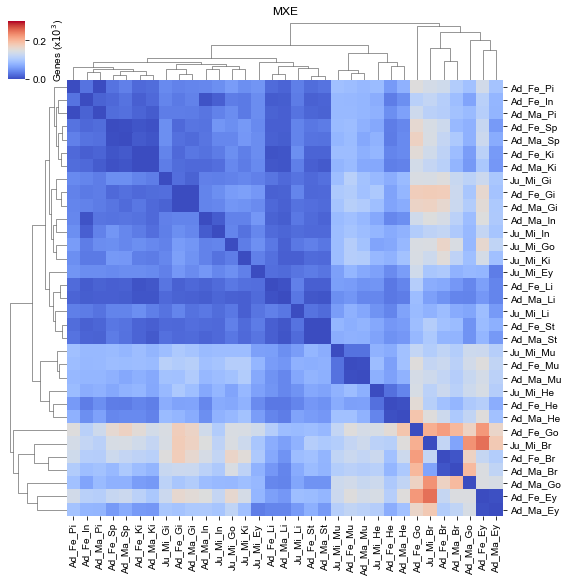

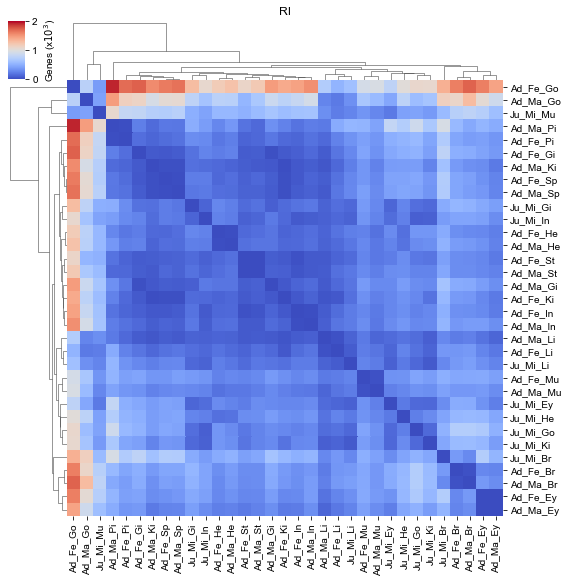

In [8]:
for t in as_type_list:
    # print(t)
    
    groups = list(sorted(set([s[:-2] for s in samples])))
    matrix = np.zeros((len(groups), len(groups)), dtype=np.int)
    for i in range(len(groups)):
        for j in range(len(groups)):
            g1 = groups[i]
            g2 = groups[j]
            if g1 >= g2:
                continue
            path = "../../3_integrate_isoforms/results/rmats/pairs2/%s_vs_%s/%s.MATS.JC.txt" % (g1, g2, t)
            d = pd.read_csv(path, sep="\t")
            d = d[d["FDR"] < 1e-6]
            value = len(set(d["GeneID"]))
            matrix[i][j] = value
            matrix[j][i] = value
            
    matrix = pd.DataFrame(matrix)
    if True:
        matrix.index = ["%s_%s_%s" % (g[0:2 ], g[6:8], g[3:5]) for g in groups]
        matrix.columns = ["%s_%s_%s" % (g[0:2 ], g[6:8], g[3:5]) for g in groups]
    else:
        matrix.index = groups
        matrix.columns = groups
    print(t, matrix.max().max())
    
    if t == "SE":
        vmax = 1.5
    elif t == "A5SS":
        vmax = 0.5
    elif t == "A3SS":
        vmax = 0.5
    elif t == "MXE":
        vmax = 0.3
    elif t == "RI":
        vmax = 2
    else:
        assert False
    
    ret = sns.clustermap(matrix/1e3, cmap="coolwarm", figsize=(8, 8), vmin=0, vmax=vmax,
                         dendrogram_ratio=0.12,
                         cbar_pos=(0.02, 0.88, 0.03, 0.1),
                         cbar_kws=dict(label="Genes (x$10^3$)", ))
    plt.sca(ret.ax_heatmap)
    ret.ax_col_dendrogram.set_title(t)

    
    ret.savefig("figures/clustermap.%s.pdf" % t, dpi=300)
    
    # break

# Analysis of sex-specific inclusion

In [290]:
vs1 = []
vs2 = []
for t in as_type_list:
    genes = []
    p = "../../3_integrate_isoforms/results/rmats/pairs2/Ad_Go_Fe_vs_Ad_Go_Ma/%s.MATS.JC.txt" % t
    d = pd.read_csv(p, sep="\t")
    d = d[d["FDR"] < 1e-6]
    v1 = sum(d["IncLevelDifference"] > 0)
    v2 = sum(d["IncLevelDifference"] < 0)
    vs1.append(v1)
    vs2.append(v2)

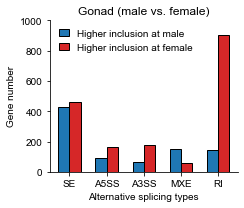

In [303]:
xs = np.arange(len(ts))

plt.figure(figsize=(3.5, 3))
plt.title("Gonad (male vs. female)")
plt.bar(xs - 0.15, vs1, width=0.3, edgecolor="black", color="C0", label="Higher inclusion at male")
plt.bar(xs + 0.15, vs2, width=0.3, edgecolor="black", color="C3", label="Higher inclusion at female")
plt.ylim(0, 1000)
plt.xticks(xs, as_type_list)
plt.xlabel("Alternative splicing types")
plt.ylabel("Gene number")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(handlelength=1, frameon=False)
plt.tight_layout()
plt.savefig("figures/inclusion_of_as.gonad.pdf", dpi=300)